# 한영 번역기 만들기2

이번 프로젝트에서는 지난 Going Deeper에서 진행했던 [Seq2seq 버전의 한영번역기](https://github.com/riverlike/Aiffel_Project/blob/main/GoingDeeper/nlp08/NLP08_Assignment_Translation_final.ipynb)를 Transformer버전으로 업그레이드 해보도록 하겠다.



![ㅇ](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FcfpTM1%2FbtrzeY2pwPd%2FKHNOoJnloGnqqxGPGDvFF1%2Fimg.png)


In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [1]:
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import tensorflow as tf

#나눔폰트 관련 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
plt.rc('font', family='NanumGothic')

## 데이터 다운로드

In [2]:
path_to_zip = tf.keras.utils.get_file(
    'korean-english-park.train.tar.gz',
    origin='https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz',
    extract=True)

print(path_to_zip)

kor_path = os.path.dirname(path_to_zip)+"/korean-english-park.train.ko"
eng_path = os.path.dirname(path_to_zip)+"/korean-english-park.train.en"

8732672/8718893 [==============================] - 0s 0us/step
/root/.keras/datasets/korean-english-park.train.tar.gz


## 데이터 정제 및 토큰화

### (1) 중복데이터 제거

In [3]:
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: raw_kor = f.read().splitlines()
    with open(eng_path, "r") as f: raw_eng = f.read().splitlines()
    assert len(raw_kor) == len(raw_eng)
    
    raw_data = []
    for kor, eng in zip(raw_kor, raw_eng):
        raw_data.append(kor + '\t' + eng) #tap키로 한영 데이터 구분

    raw = set(raw_data)  #집합 set으로 변환 - 중복제거
    cleaned_corpus = list(raw) #list로 변환

    total_len = len(raw_kor)
    cleaned_len = len(cleaned_corpus)
    dup_examples = total_len - cleaned_len
    print('total sentences', total_len)
    print('duplicated sentences', dup_examples)
    print('cleaned sentences', cleaned_len)

    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)

total sentences 94123
duplicated sentences 15155
cleaned sentences 78968


### (2) 데이터 정제

 - 모든 입력을 소문자로 변환
 - 알파벳, 문장부호, 한글만 남기고 모두 제거
 - 문장부호 양옆에 공백을 추가
 - 문장 앞뒤의 불필요한 공백을 제거

In [4]:
import re
def preprocess_sentence(sentence):    
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1", sentence)       
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z가-힣?.!,]+", " ", sentence) 

    sentence = sentence.strip()    
    return sentence

eng_corpus = []
kor_corpus = []

#한글 말뭉치 kor_corpus 와 영문 말뭉치 eng_corpus 를 각각 분리한 후, 정제
for pair in cleaned_corpus:
    k, e = pair.split("\t")

    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

### (3) 토큰화

- Sentencepiece를 활용하여 학습한 tokenizer를 생성
 - 단어 사전 사이즈 설정 (기본: 20,000)
 - 코퍼스로 학습 후 저장된 model 파일을 SentencePieceProcessor() 클래스에 Load()한 후 반환
 - 특수 토큰의 인덱스 설정 : \<PAD> : 0 / \<BOS> : 1 / \<EOS> : 2 / \<UNK> : 3

- 토큰화
 - 문장 길이가 50 이하인 데이터에 대하여 토큰화처리
 - 학습이 오래걸리므로 tqdm모듈로 processing과정 표시

In [5]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 5.1 MB/s 


In [6]:
import sentencepiece as spm
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm.notebook import tqdm    # Process 과정을 보기 위해

# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus,
                        vocab_size,
                        lang="ko", #model, vocab file name
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):    
    spm.SentencePieceTrainer.Train(sentence_iterator=iter(corpus), model_prefix=lang, vocab_size=vocab_size,
                               pad_id=pad_id,                
                               unk_id=unk_id,
                               bos_id=bos_id,
                               eos_id=eos_id)

    # Load pretrained tokenizer model.
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(lang+'.model')
    if lang == 'en':
        tokenizer.SetEncodeExtraOptions('bos:eos') #set start, end token

    return tokenizer    


findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


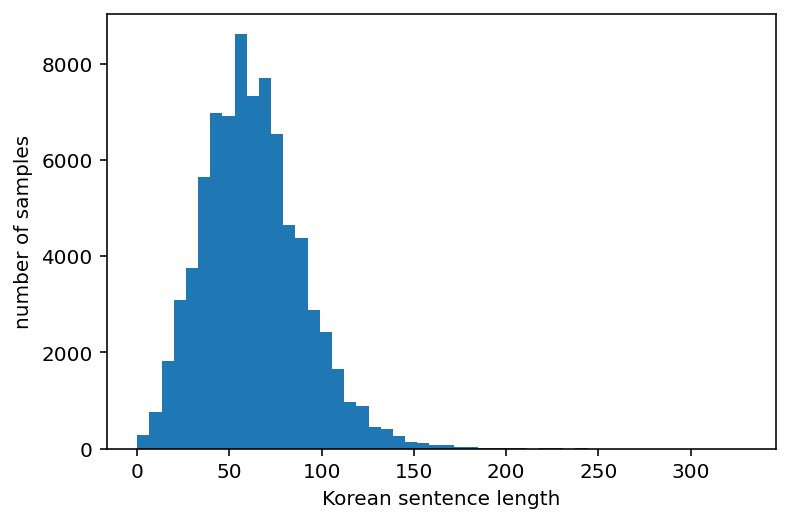

In [7]:
plt.hist([len(sen) for sen in kor_corpus], bins=50)
plt.xlabel('Korean sentence length')
plt.ylabel('number of samples')
plt.show()

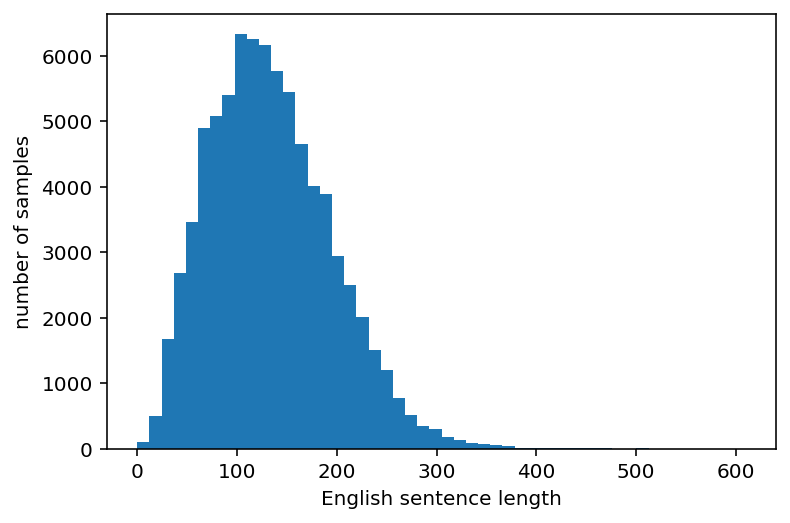

In [8]:
plt.hist([len(sen) for sen in eng_corpus], bins=50)
plt.xlabel('English sentence length')
plt.ylabel('number of samples')
plt.show()

In [9]:
def tokenizing(ko_tokenizer, en_tokenizer, kor_corpus, eng_corpus):
    src_corpus = []
    tgt_corpus = []
    #문장을 구성하는 단어 개수가 한글 70, 영문 150 이상인경우 제외
    for idx in tqdm(range(len(kor_corpus))):
        if len(kor_corpus[idx]) > 70 or len(eng_corpus[idx]) > 150:
            continue
        src_corpus.append(ko_tokenizer.EncodeAsIds(kor_corpus[idx]))        
        tgt_corpus.append(en_tokenizer.EncodeAsIds(eng_corpus[idx]))        

    # 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
    src_corpus = pad_sequences(src_corpus, padding='post')
    tgt_corpus = pad_sequences(tgt_corpus, padding='post')

    return src_corpus, tgt_corpus

In [ ]:
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 25000

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
assert len(kor_corpus) == len(eng_corpus)

enc_train, dec_train = tokenizing(ko_tokenizer, en_tokenizer, kor_corpus, eng_corpus)
enc_train.shape, dec_train.shape

  0%|          | 0/78968 [00:00<?, ?it/s]

((42358, 40), (42358, 46))

## 모델 설계

### 트랜스포머 모듈 구현 

In [ ]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table


'''
인코더의 첫번째 서브층 : Query = Key = Value
디코더의 첫번째 서브층 : Query = Key = Value
디코더의 두번째 서브층 : Query : 디코더 행렬 / Key = Value : 인코더 행렬
'''    
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model) # Linear Layer
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)        

        """
        Scaled QK 값 구하기
        """
        QK = tf.matmul(Q, K, transpose_b=True)
        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9) 

        """
        1. Attention Weights 값 구하기 -> attentions
        2. Attention 값을 V에 곱하기 -> out
        """ 
        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
        

    def split_heads(self, x):
        """
        Embedding을 Head의 수로 분할하는 함수

        x: [ batch x length x emb ]
        return: [ batch x length x heads x self.depth ]
        """
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        """
        분할된 Embedding을 하나로 결합하는 함수

        x: [ batch x length x heads x self.depth ]
        return: [ batch x length x emb ]
        """
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))


        return combined_x
    

    def call(self, Q, K, V, mask):
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Linear_in(Q, K, V) -> WQ, WK, WV
        Step 2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        Step 3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split)
                 -> out, attention_weights
        Step 4: Combine Heads(out) -> out
        Step 5: Linear_out(out) -> out

        """
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)

        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)

        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)

        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights

class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

# DecoderLayer 클래스를 작성하세요.
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

### 트랜스포머의 마스킹
트랜스포머에는 총 세 가지 어텐션이 존재하며, 모두 멀티 헤드 어텐션을 수행하고, 멀티 헤드 어텐션 함수 내부에서 스케일드 닷 프로덕트 어텐션 함수를 호출하는데 각 어텐션 시 함수에 전달하는 마스킹은 다음과 같다.

- 인코더의 패딩 마스크(padding mask)
 - 인코더의 셀프 어텐션에서 사용
 - 입력 문장에 PAD 토큰이 있을 경우 어텐션에서 사실상 제외하기 위한 연산
- 디코더의 룩-어헤드 마스크(look-ahead mask)
 - 디코더의 첫번째 서브층(마스크드 셀프 어텐션)에서 사용
 - 자기 자신보다 미래에 있는 단어들은 참고하지 못하도록 마스킹처리
 - 어텐션 스코어 행렬의 각 행을 보면 자기 자신과 그 이전 단어들만을 참고할 수 있음
- 디코더의 패딩 마스크(padding mask)
 - 디코더의 두번째 서브층(셀프 어텐션)에서 사용
 - 입력 문장에 PAD 토큰이 있을 경우 마스킹처리

![ㅇ](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FWZMbk%2FbtrzdMIeM4M%2FA747WrA8MGRIm8k6bnrpCK%2Fimg.png)

In [ ]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

### learning rate, optimizer 정의

In [ ]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

### loss 함수 정의

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

## 모델 학습

In [ ]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

In [ ]:
src_vocab_size = ko_tokenizer.GetPieceSize()
tgt_vocab_size = en_tokenizer.GetPieceSize()

print ('SRC_VOCAB_SIZE :', src_vocab_size)
print ('TGT_VOCAB_SIZE :', tgt_vocab_size)

# 하이퍼파라미터
D_MODEL = 512
NUM_LAYERS = 4
NUM_HEADS = 8
DFF = 512
POS_LEN = 50
DROPOUT = 0.2

transformer = Transformer(
    n_layers=NUM_LAYERS,
    d_model=D_MODEL,
    n_heads=NUM_HEADS,
    d_ff=DFF,
    src_vocab_size=src_vocab_size,
    tgt_vocab_size=tgt_vocab_size,
    pos_len=POS_LEN,
    dropout=DROPOUT)

learning_rate = LearningRateScheduler(D_MODEL)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

SRC_VOCAB_SIZE : 25000
TGT_VOCAB_SIZE : 25000


In [ ]:
from tqdm.notebook import tqdm
import random

BATCH_SIZE = 64
EPOCHS = 20

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE)) 
    random.shuffle(idx_list)
    t_bar = tqdm(idx_list)

    for (batch, idx) in enumerate(t_bar):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss

        t_bar.set_description_str('Epoch %2d' % (epoch + 1))
        t_bar.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
        t_bar.update()

  0%|          | 0/662 [00:00<?, ?it/s]

  0%|          | 0/662 [00:00<?, ?it/s]

  0%|          | 0/662 [00:00<?, ?it/s]

  0%|          | 0/662 [00:00<?, ?it/s]

  0%|          | 0/662 [00:00<?, ?it/s]

  0%|          | 0/662 [00:00<?, ?it/s]

  0%|          | 0/662 [00:00<?, ?it/s]

  0%|          | 0/662 [00:00<?, ?it/s]

  0%|          | 0/662 [00:00<?, ?it/s]

  0%|          | 0/662 [00:00<?, ?it/s]

  0%|          | 0/662 [00:00<?, ?it/s]

  0%|          | 0/662 [00:00<?, ?it/s]

  0%|          | 0/662 [00:00<?, ?it/s]

  0%|          | 0/662 [00:00<?, ?it/s]

  0%|          | 0/662 [00:00<?, ?it/s]

  0%|          | 0/662 [00:00<?, ?it/s]

  0%|          | 0/662 [00:00<?, ?it/s]

  0%|          | 0/662 [00:00<?, ?it/s]

  0%|          | 0/662 [00:00<?, ?it/s]

  0%|          | 0/662 [00:00<?, ?it/s]

## 테스트

In [ ]:
# 번역 생성 함수
def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = pad_sequences([tokens], maxlen=enc_train.shape[-1], padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns = model(_input, output, enc_padding_mask,combined_mask,dec_padding_mask)
                
        predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [ ]:
# Attention 시각화 함수
def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [ ]:
# 번역 생성 및 Attention 시각화 결합
def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print(' {} --> {}'.format(sentence, result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [ ]:
def train_evaluate(examples, epochs, plot_attention=False):
    for epoch in range(epochs):
        total_loss = 0

        idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
        random.shuffle(idx_list)
        t_bar = tqdm(idx_list)

        for (batch, idx) in enumerate(t_bar):
            batch_loss, enc_attns, dec_attns, dec_enc_attns = \
            train_step(enc_train[idx:idx+BATCH_SIZE],
                        dec_train[idx:idx+BATCH_SIZE],
                        transformer,
                        optimizer)

            total_loss += batch_loss

            t_bar.set_description_str('Epoch %2d' % (epoch + 1))
            t_bar.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

        for example in examples:
            translate(example, transformer, ko_tokenizer, en_tokenizer, plot_attention)

예문중 번역이 잘되는 문장을 시각화를 하여 어텐션이 어떻게 작용하는지 살펴보자.

  0%|          | 0/662 [00:00<?, ?it/s]

 오바마는 대통령이다. --> obama is a president .
Encoder Layer 1


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


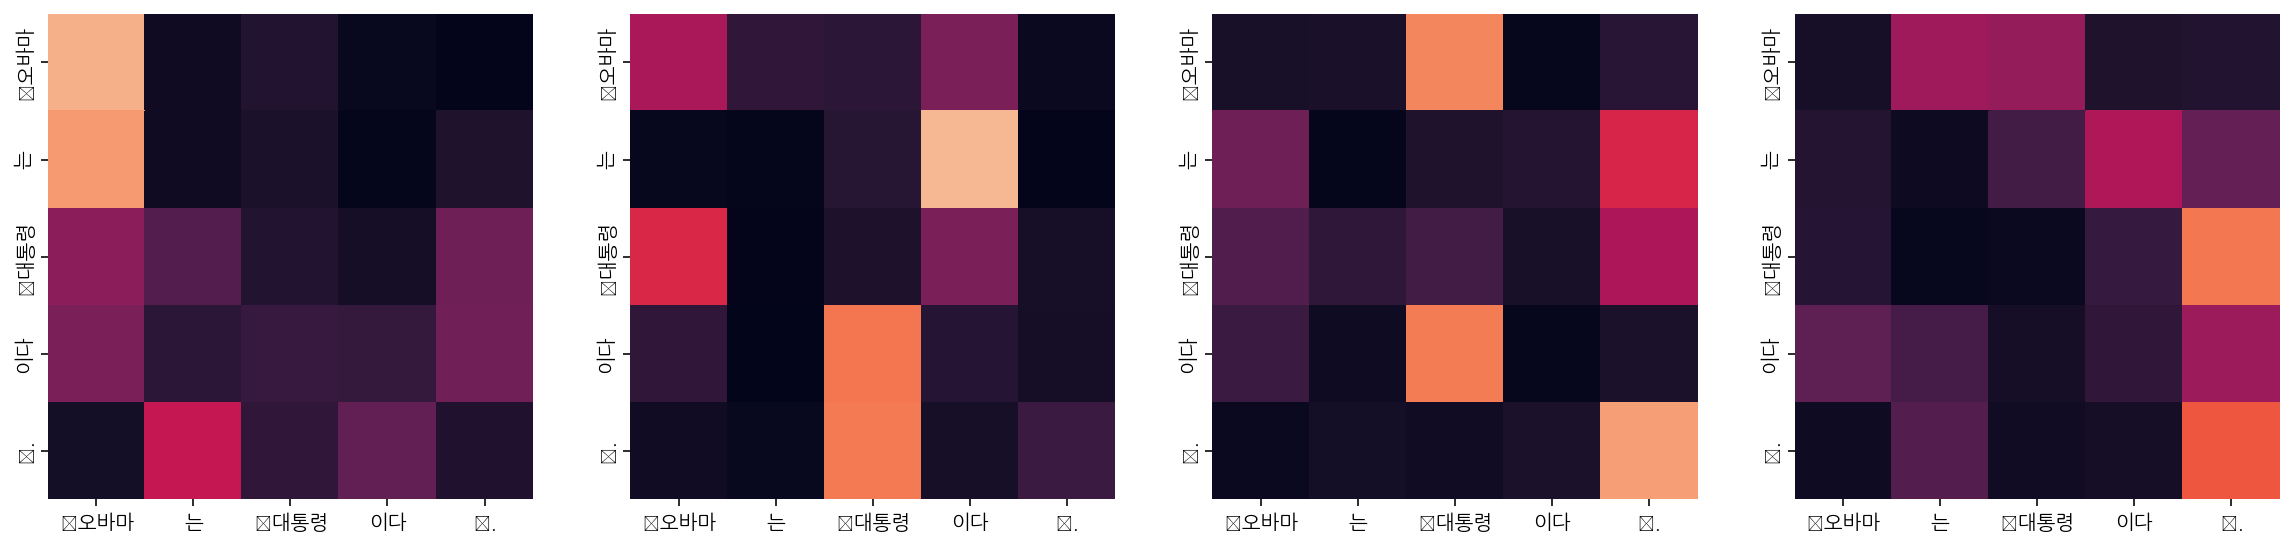

Encoder Layer 2


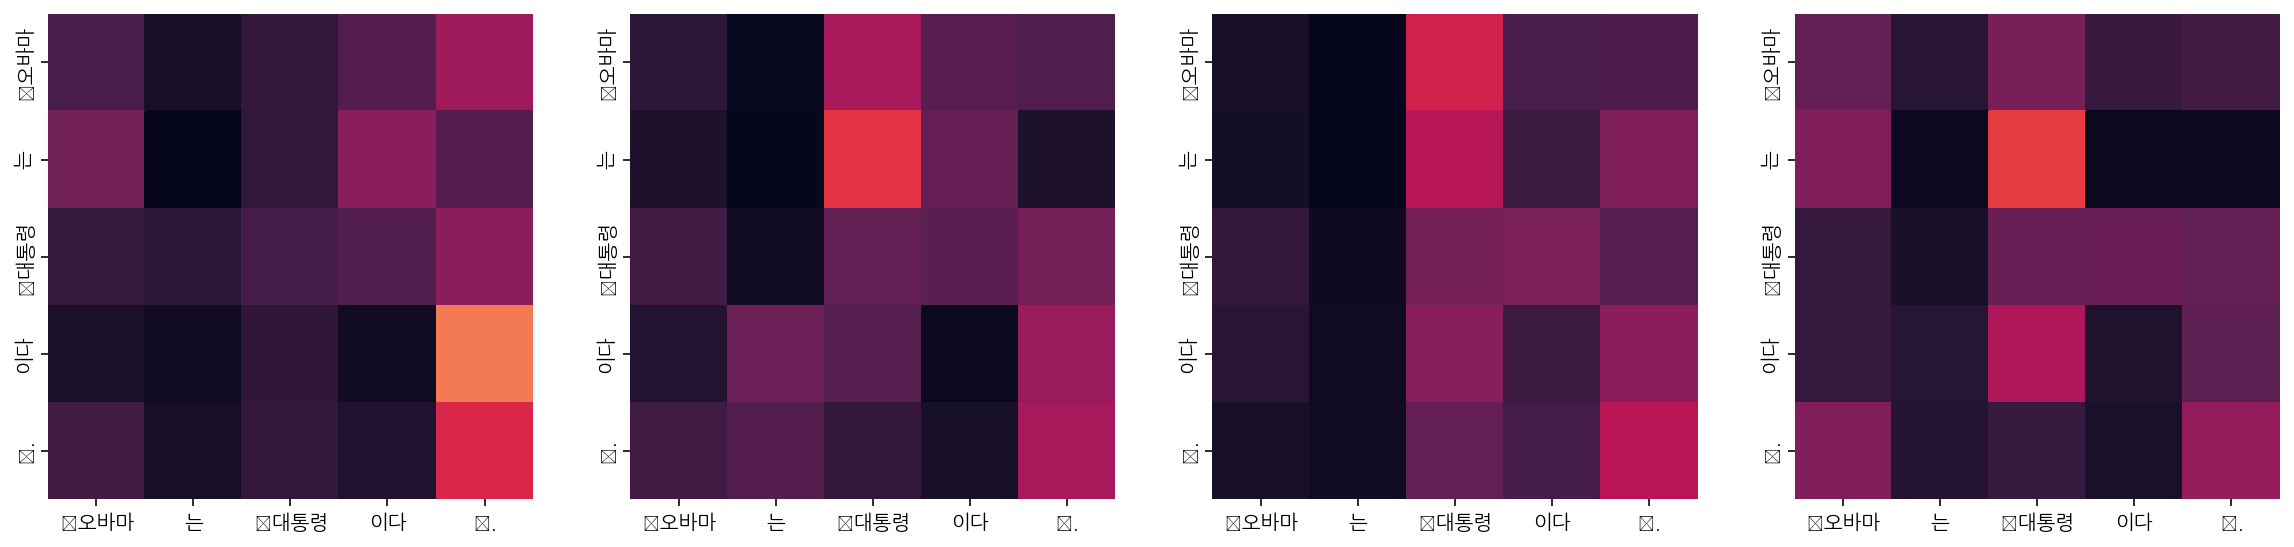

Decoder Self Layer 1


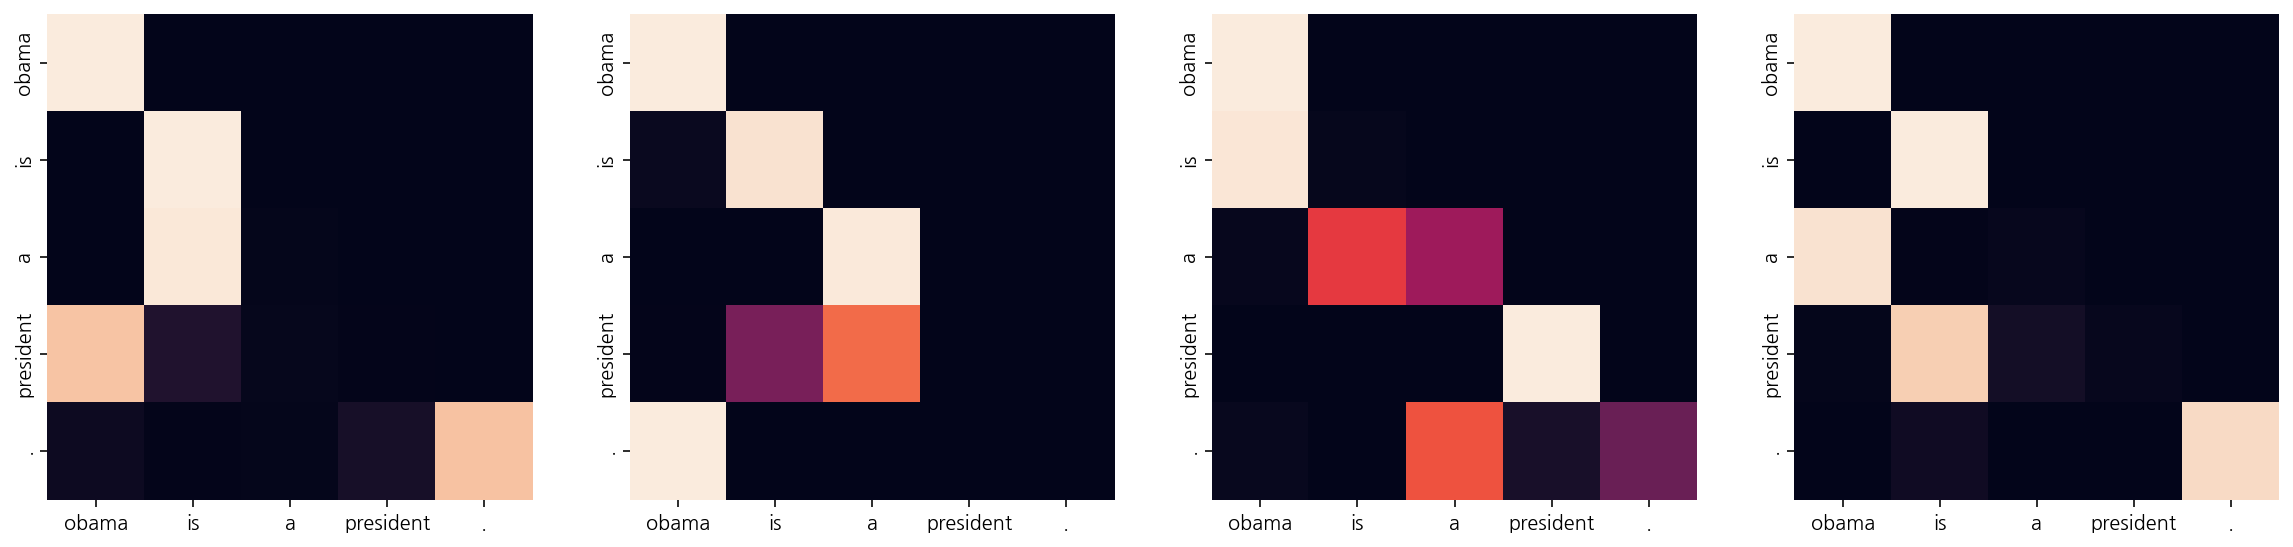

Decoder Src Layer 1


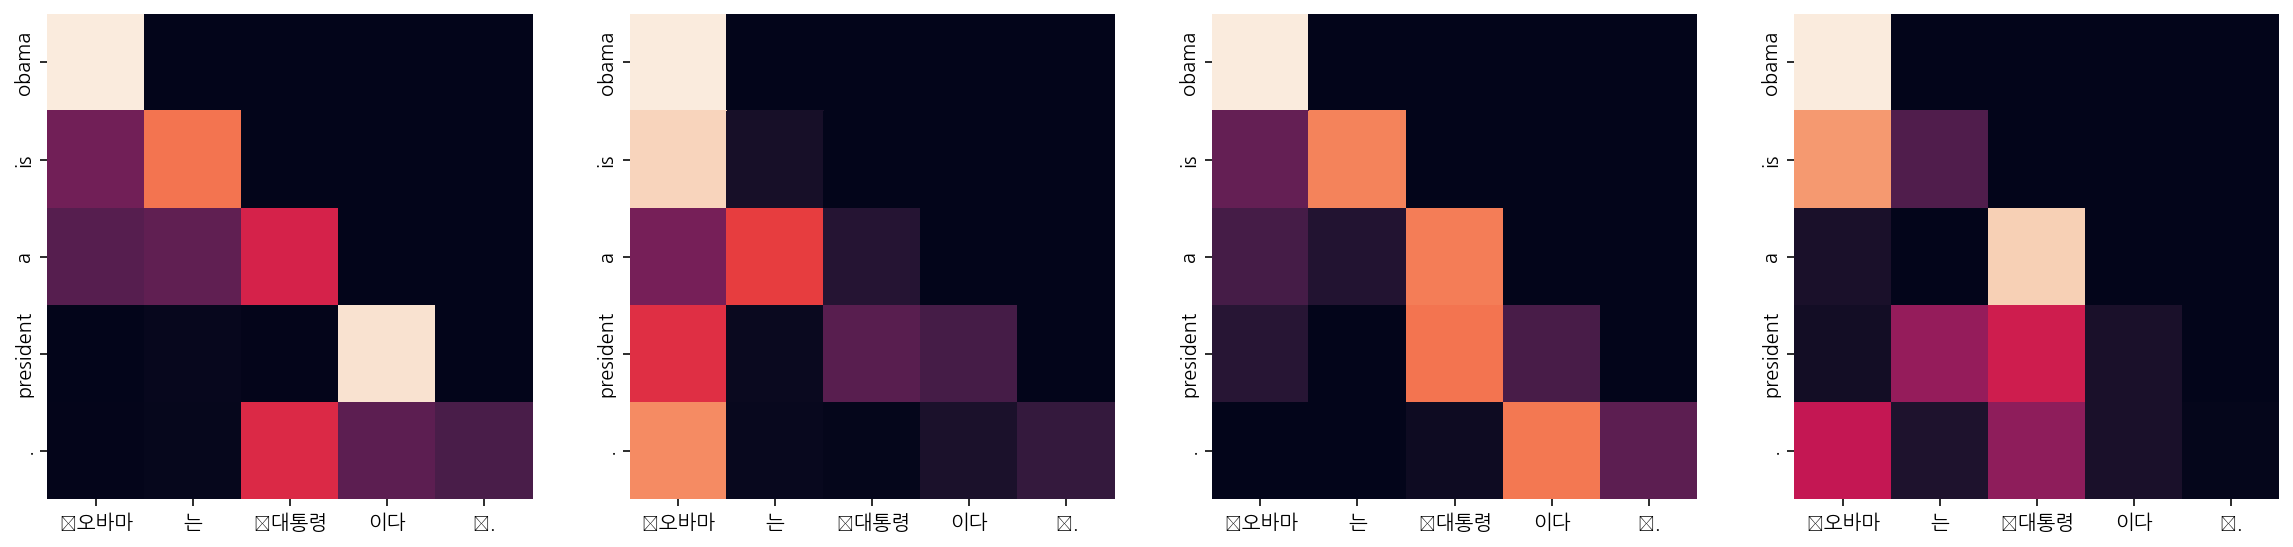

Decoder Self Layer 2


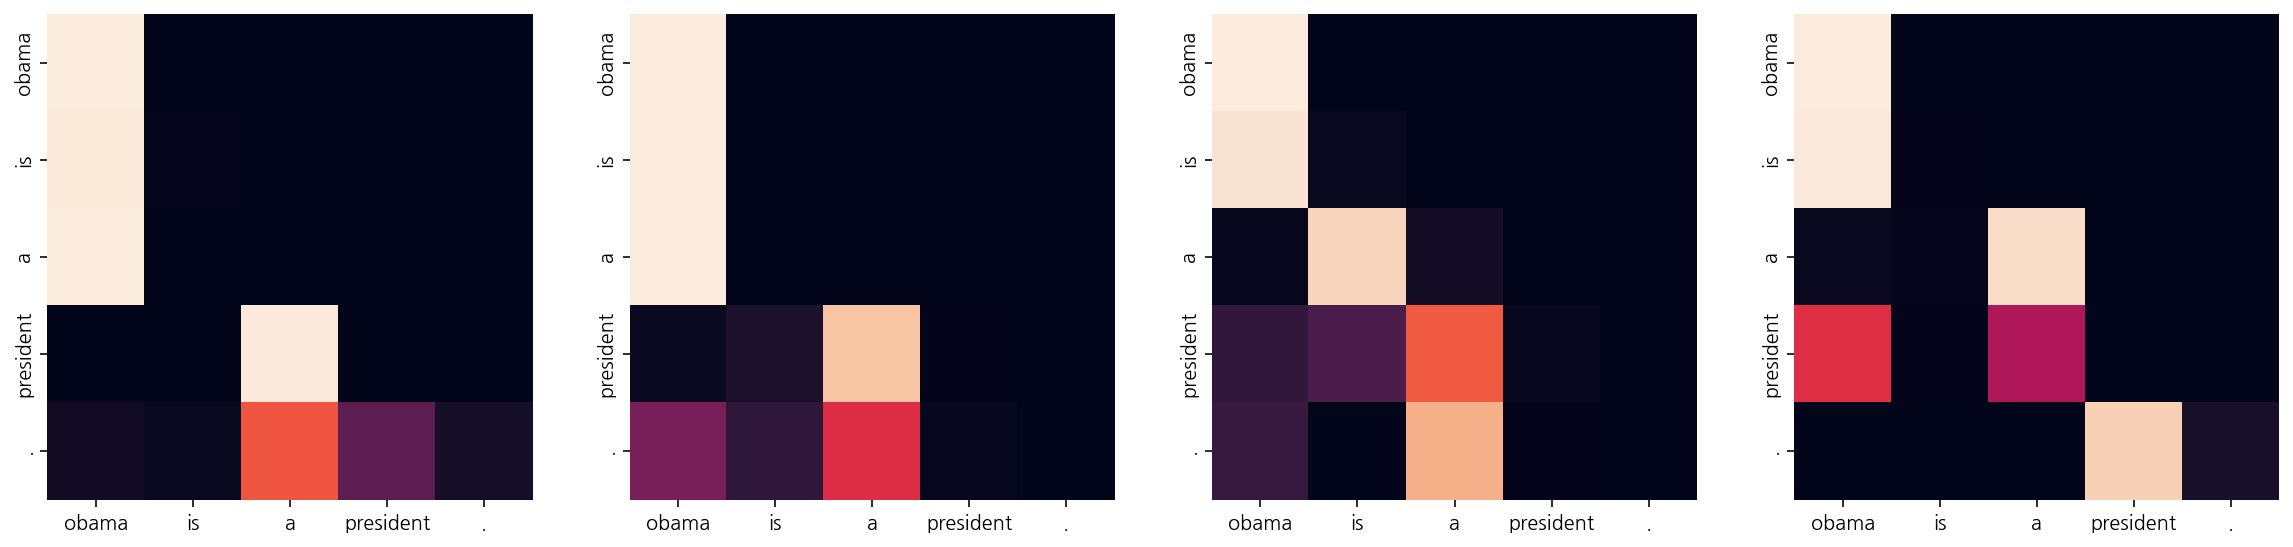

Decoder Src Layer 2


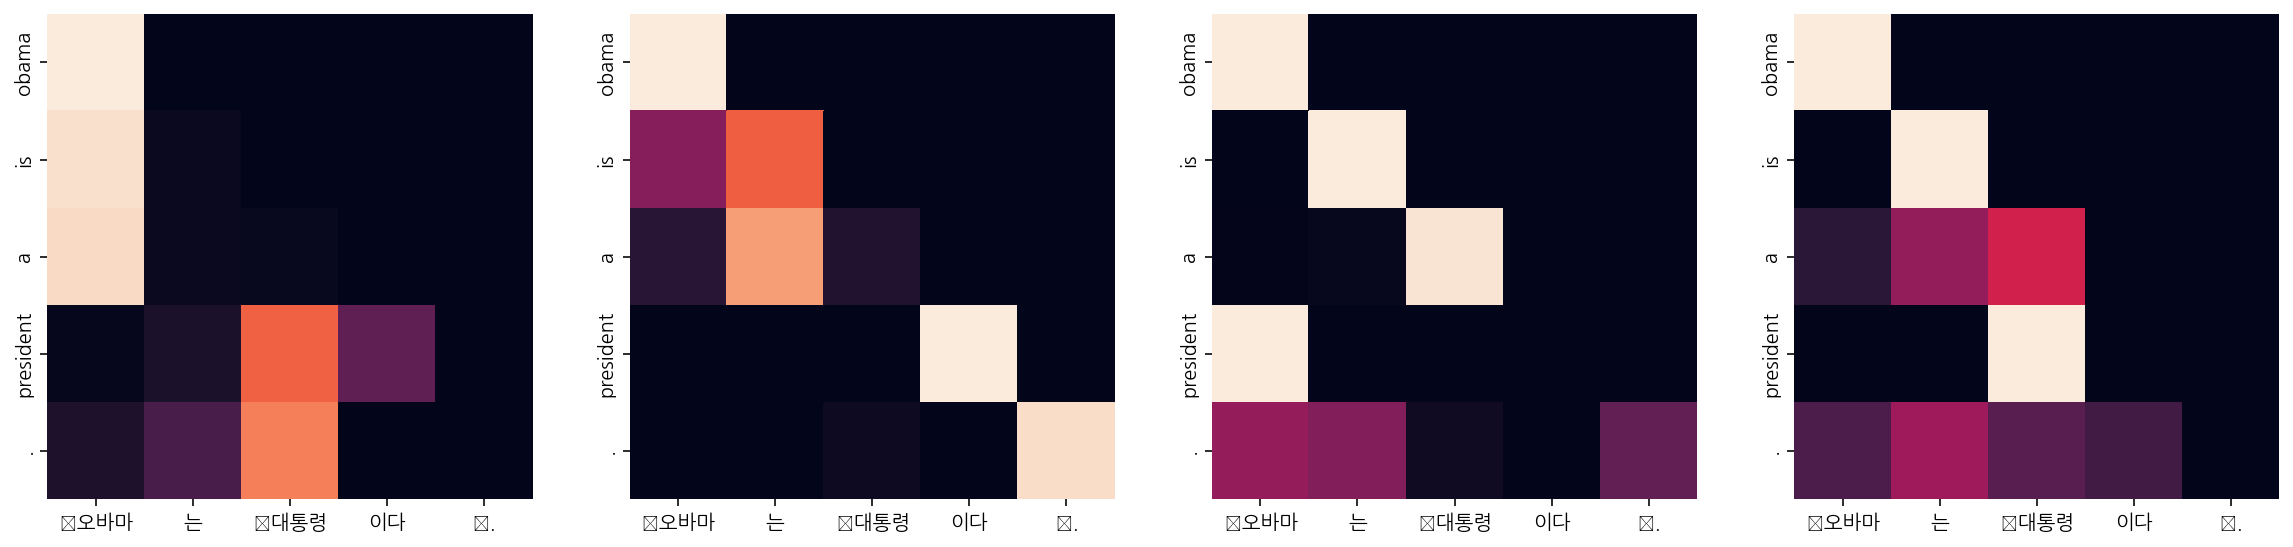

In [ ]:
train_evaluate(["오바마는 대통령이다."], epochs = 1,plot_attention=True)

  0%|          | 0/662 [00:00<?, ?it/s]

 일곱 명의 사망자가 발생했다. --> seven people were killed in the region .
Encoder Layer 1


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


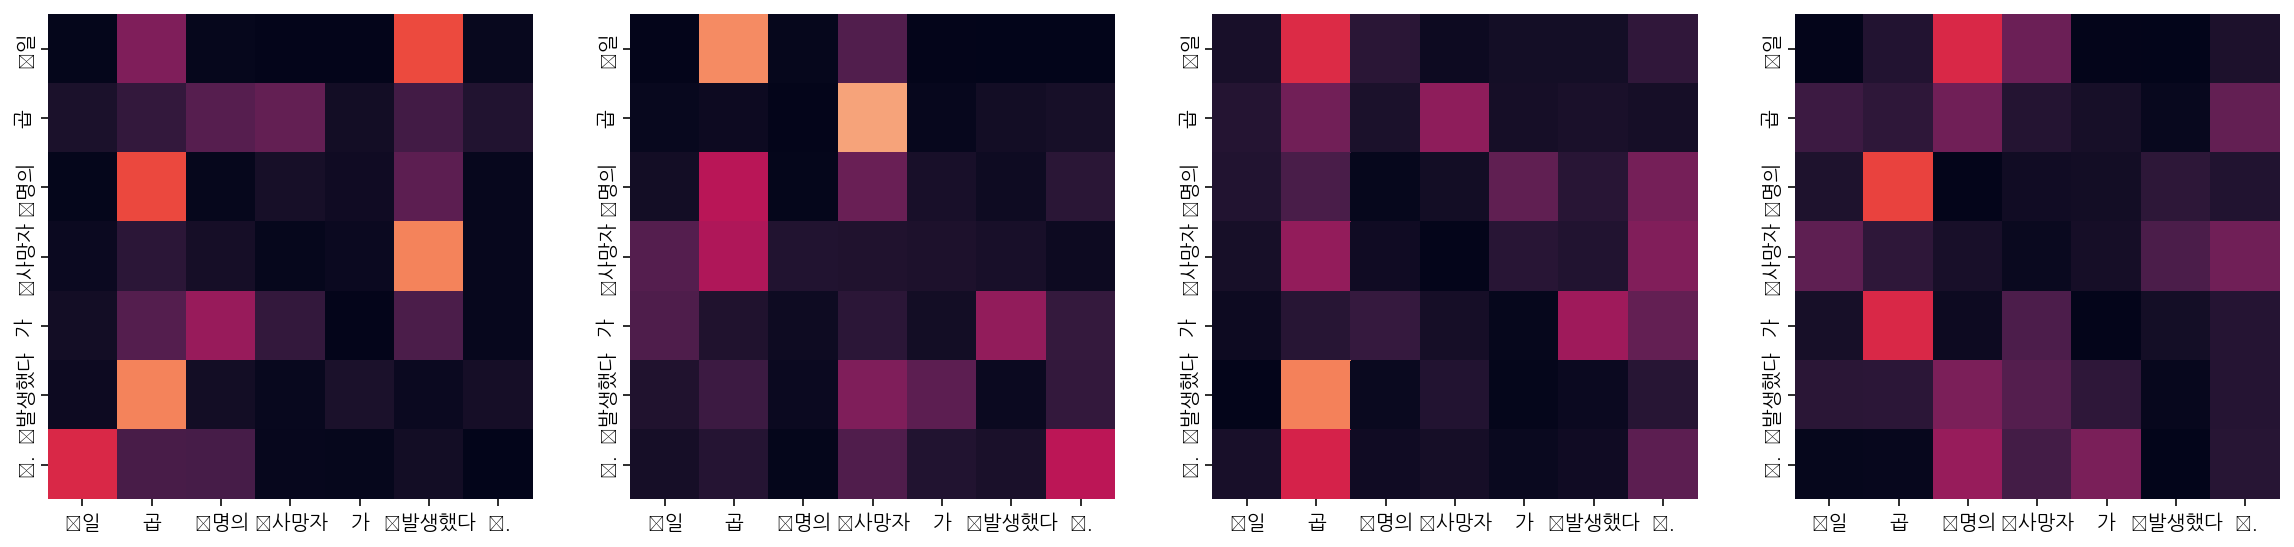

Encoder Layer 2


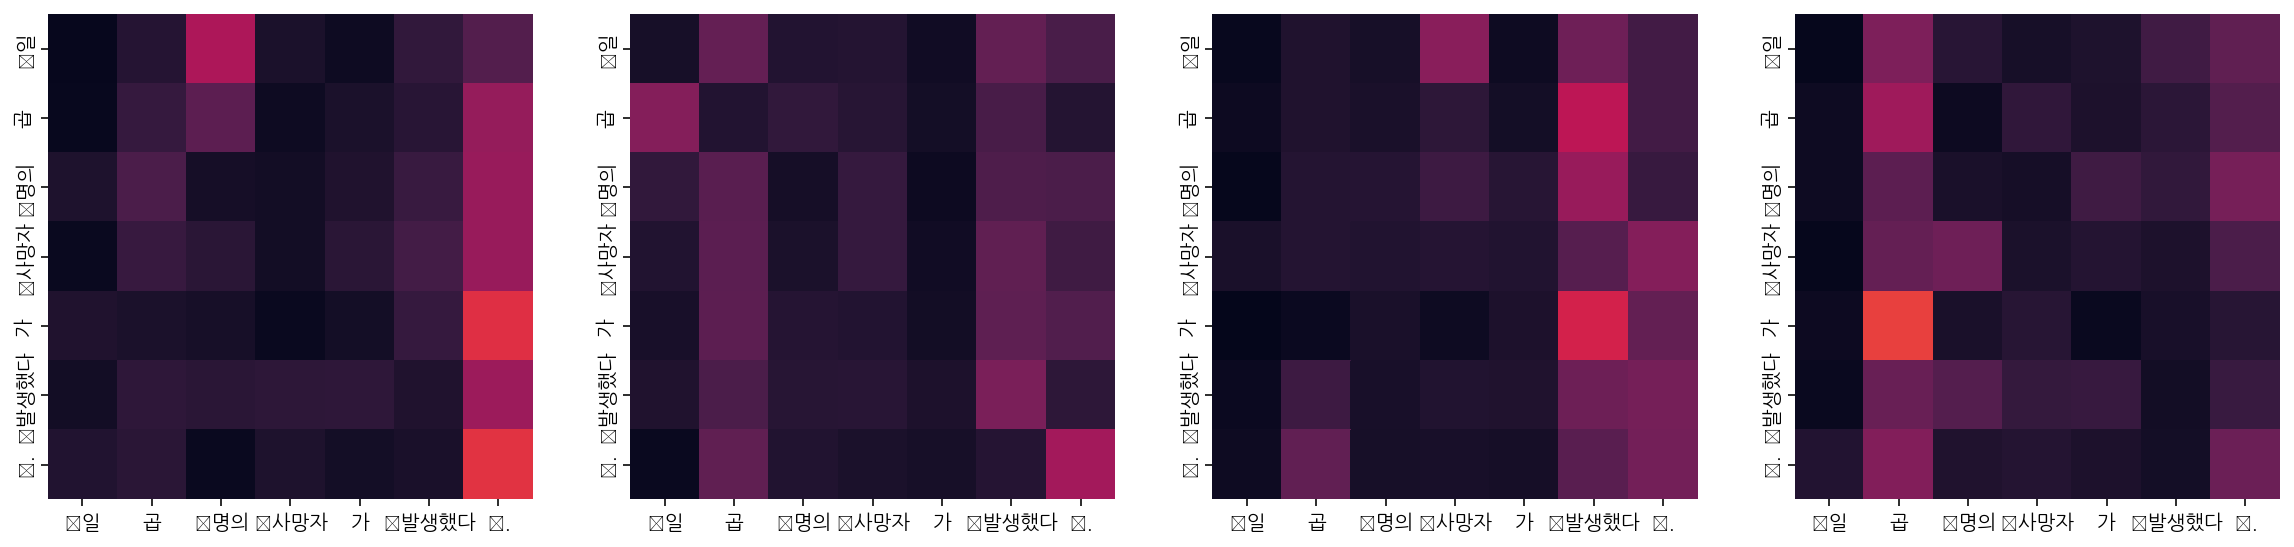

Decoder Self Layer 1


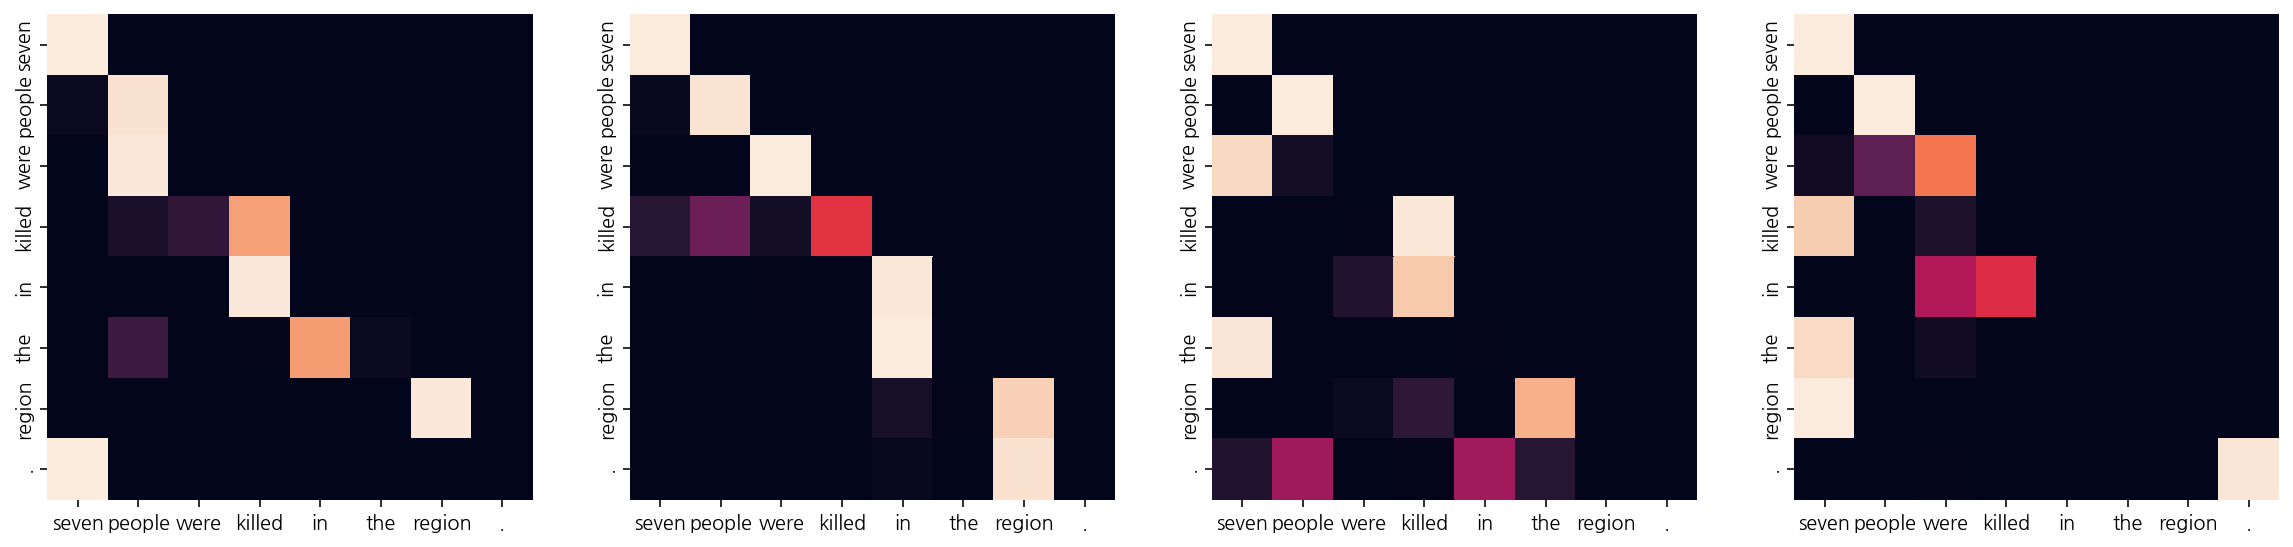

Decoder Src Layer 1


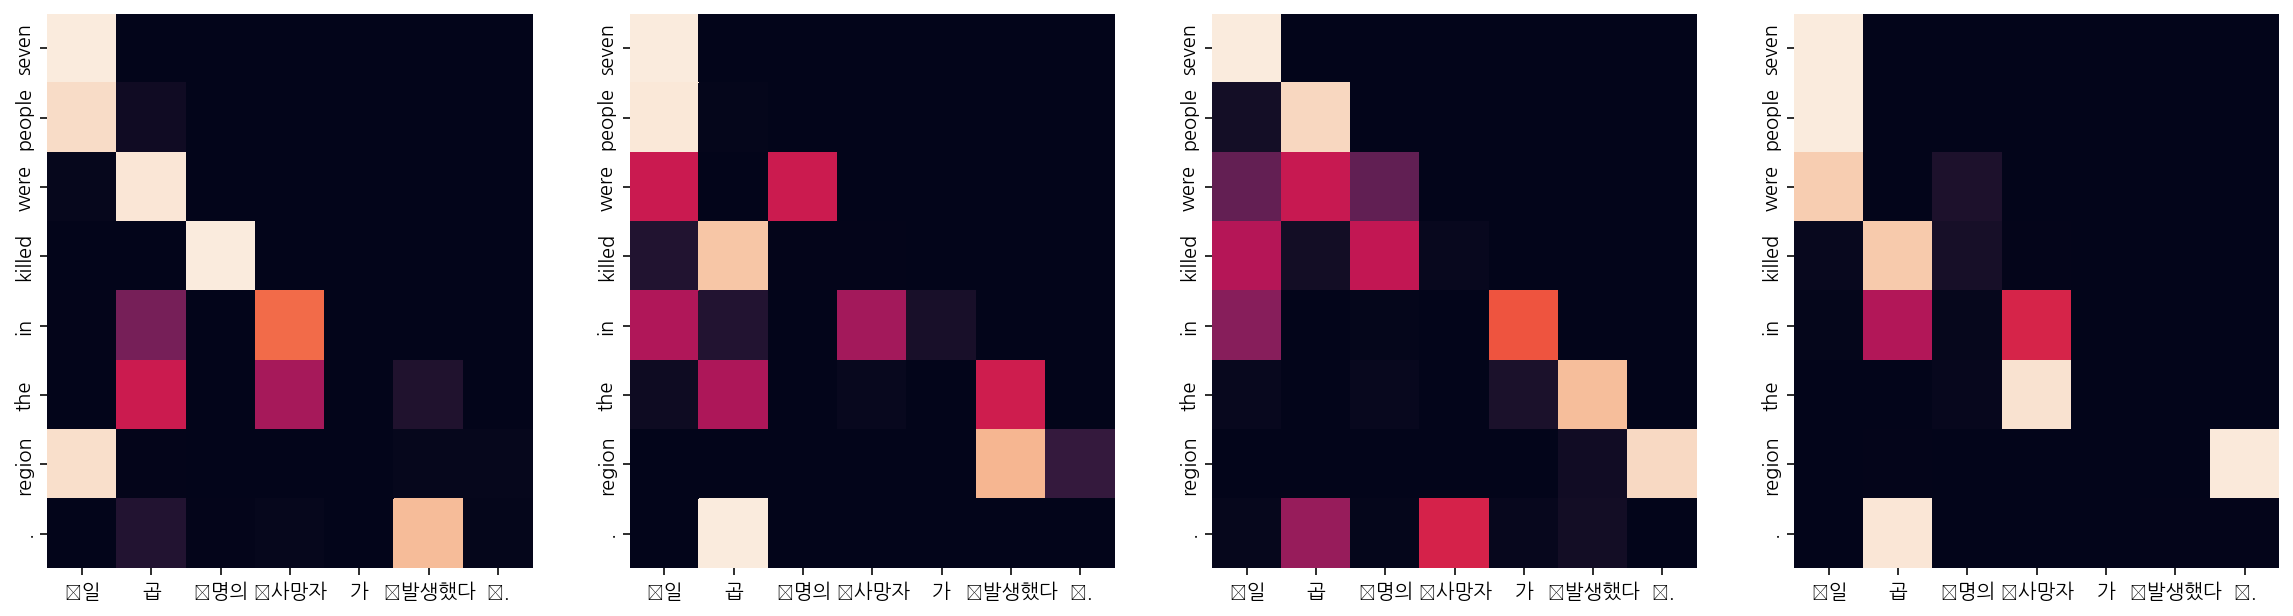

Decoder Self Layer 2


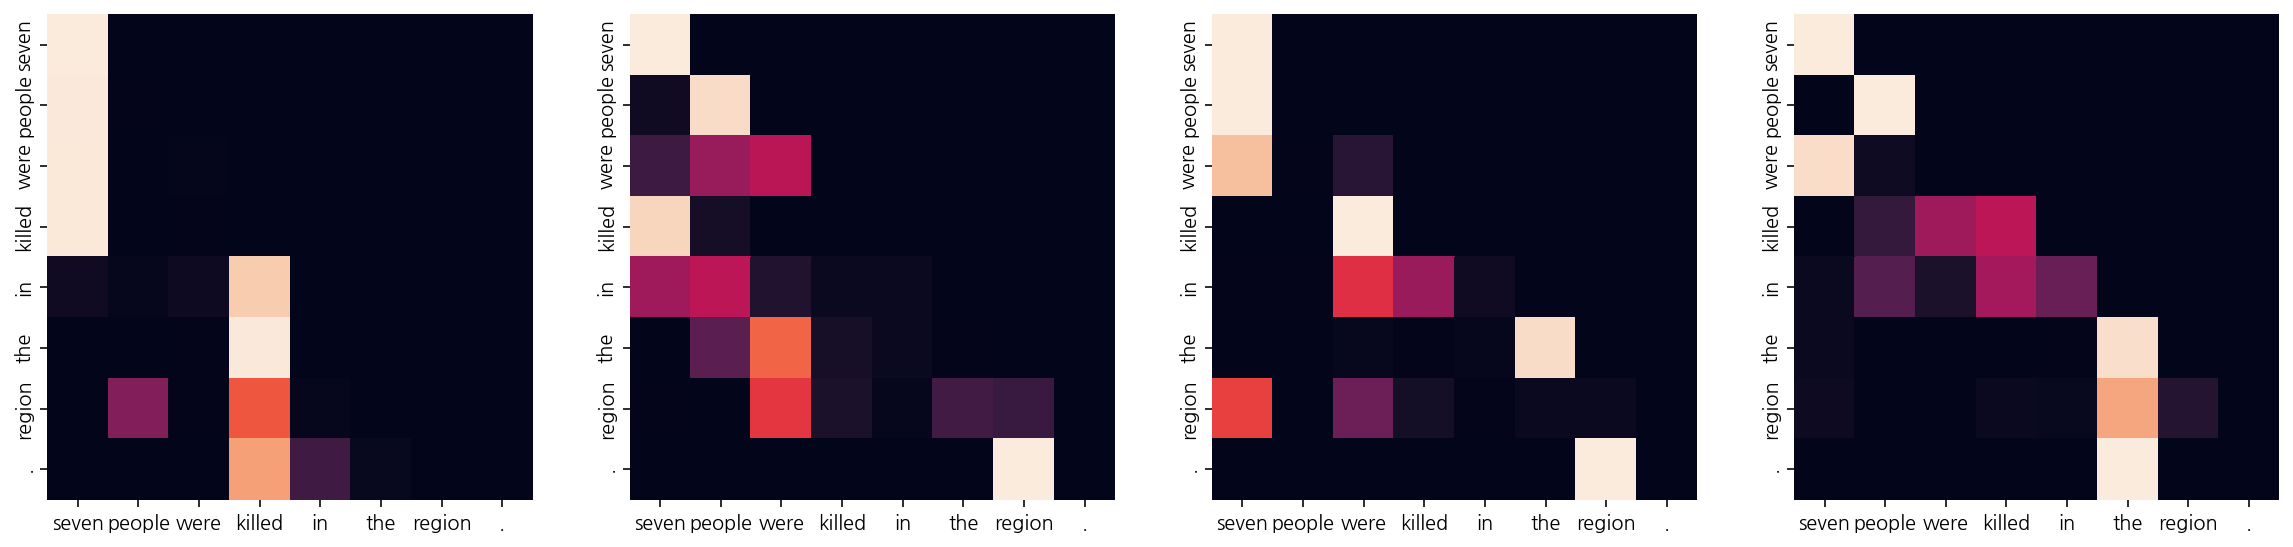

Decoder Src Layer 2


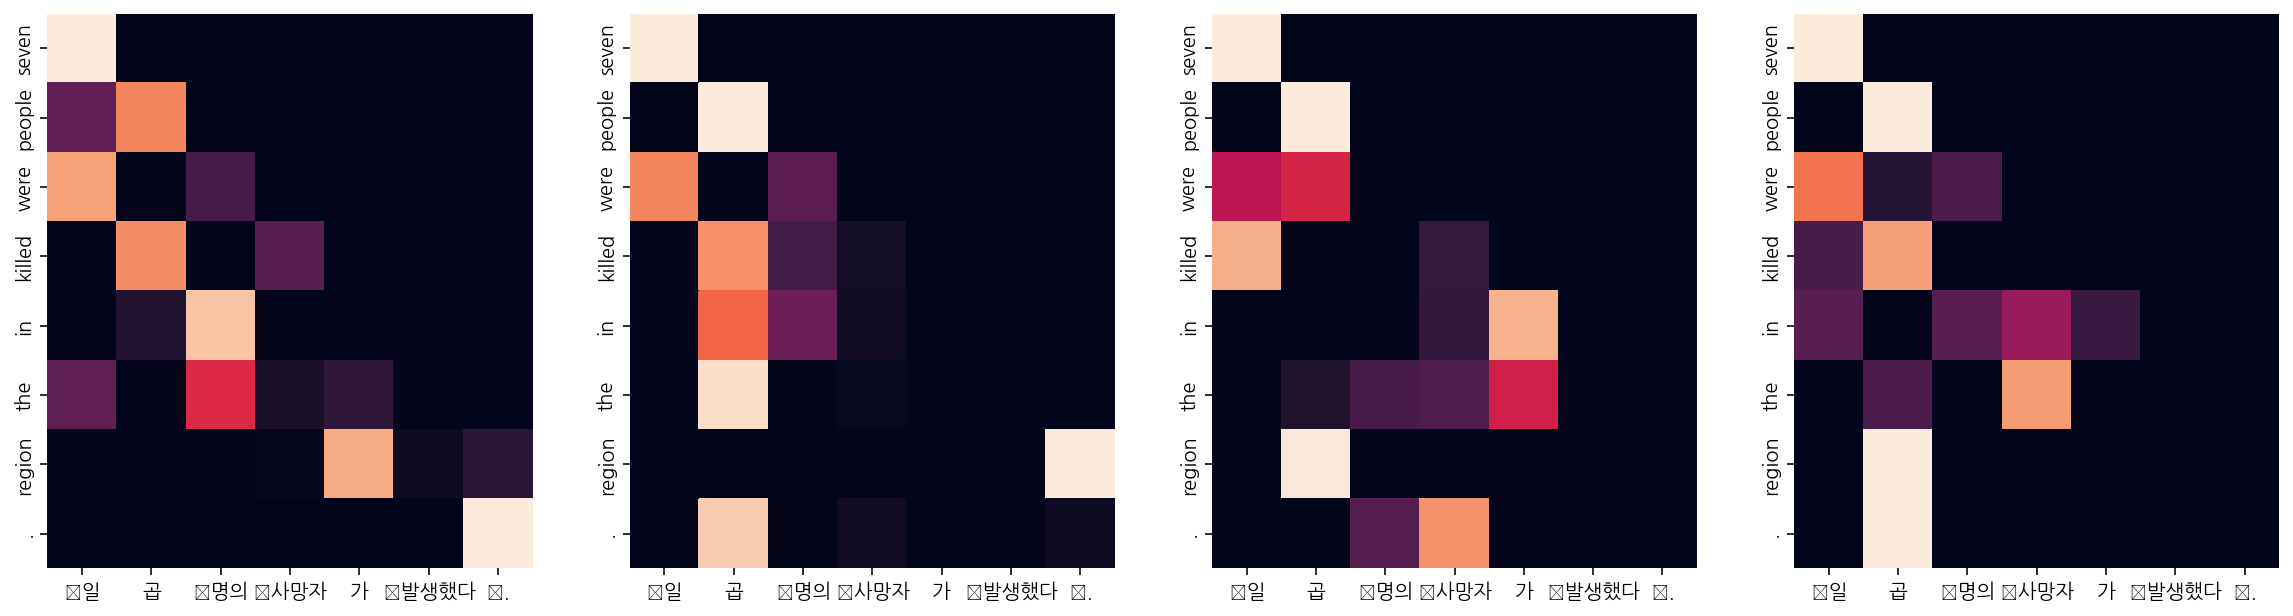

In [ ]:
train_evaluate(["일곱 명의 사망자가 발생했다."], epochs = 1,plot_attention=True)

---
## 정리.

**결과에 대한 회고.**
- 절반의 성공.
 - 이번 프로젝트는 트랜스포머모델을 사용하여 번역을 시도해보았다. 같은 데이터셋으로 seq2seq 모델보다 좋은 문장을 번역하는 모습을 보였다. 과제로 주어진 4문장중 2형식에 해당되는 1,4번문장은 한영단어를 잘 매칭하는반면 2,3번문장의 경우 제대로된 문장을 뽑아내지 못했다. 데이터셋구성이나 하이퍼파라미터의 변경으로도 2,3번 문장과 유사한 번역이 나오지않았다. 
- 모델 성능 개선을 위한 지표가 없다?
 - 모델을 학습시키며 Loss값이 주는것을 보면 어느 정도 학습의 진행되고 있는지 알수는 있지만 학습의 방향, 학습의 질이 좋은것인지는 알수 없다. 성능지표가 없고 loss만 참고해 학습을 하니 무엇이 문제인지 쉽게 알기어렵다. 
 
 - LMS의 다음노드에서 이 부분과 관련된 프로젝트가 있어 기대가 된다.

**성능개선을 위한 실험.**

- 기본적으로 많은 문장의 샘플을 포함하는 방향으로 학습을 진행했다. 하이퍼파라미터를 조정하는것보다 데이터셋을 조정할때 번역의 품질이 더 향상되었기 때문이다. 

1. Dataset : Korean corpus(19325, 30), English corpus(19325, 32)
```
오바마는 대통령이다. --> obama is the obama s president , the obama said .
시민들은 도시 속에 산다. --> the ap s robert reed is beer dream of the vote
커피는 필요 없다. --> any rate is compounding coffee
일곱 명의 사망자가 발생했다. --> a total of miners were killed .
```

2. Dataset : Korean corpus(42358, 41), English corpus(42358, 46)
```
오바마는 대통령이다. --> obama is a president .
시민들은 도시 속에 산다. --> over the years , hill stays town is a long way .
커피는 필요 없다. --> the coffee is well .
일곱 명의 사망자가 발생했다. --> seven other people were killed .
```


|No|kor단어|eng단어|dataset shape|vocab| HP| Epoch |Train Loss|Evaluate Loss|
|---|---|---|---|---|---|---|---|---|
|1.| 50|100|(19325, 30), (19325, 32)| 20000||10|1.2| 0.2 |
|2. | **70**|**150**|(42358, 41), (42358, 46)| 20000||10|0.8| 0.18 |
|3. | 70|150|(42358, 40), (42358, 46)| **25000**||20|0.2| 0.1 |
|4.-2 | 70|150|(42358, 41), (42358, 46)| 20000|**NUM_LAYERS = 6**|20|0.8| 0.18 |
|5.-2 | 70|150|(42358, 41), (42358, 46)| 20000|**DFF = 1024**|20|0.8| 0.18 |

> Train Loss  : 학습이 끝난시점의 loss값
> Evaluate Loss : 마지막 검증시점의 loss값

3. 4,5번 실험에서 2번 모델을 베이스로 하이퍼파라미터를 조정해보았지만  Loss값이 줄어든부분외에 번역문장이 크게 좋아지지않았다. 



